# Two Moons Flux1 Flow Matching Example


---
This notebook demonstrates conditional flow-matching on the Two Moons task using JAX and Flax. 

**About Simulation-Based Inference (SBI):** SBI refers to a class of methods for inferring parameters of complex models when the likelihood function is intractable, but simulation is possible. SBI algorithms learn to approximate the posterior distribution over parameters given observed data, enabling inference in scientific and engineering domains where traditional methods fail.

**The Two Moons Dataset:**
The Two Moons dataset is a two-dimensional simulation-based inference benchmark designed to test an algorithm's ability to handle complex posterior distributions. Its posterior is both bimodal (two distinct peaks) and locally crescent-shaped, making it a challenging task for inference algorithms. The primary purpose of this benchmark is to evaluate how well different methods can capture and represent multimodality and intricate structure in the posterior.

**Purpose of This Notebook:**
This notebook trains and evaluates a Flux1 flow-matching model on the Two Moons task. The goal is to assess the model's ability to learn and represent a non-trivial posterior distribution with both global (bimodal) and local (crescent-shaped) complexity.

## Table of Contents
| Section | Description |
|---|---|
| 1. Introduction & Setup | Overview, environment, device, autoreload |
| 2. Task & Data Preparation | Define task, visualize data, create datasets |
| 3. Model Configuration & Definition | Load config, set parameters, instantiate model |
| 4. Training | Train or restore model, manage checkpoints |
| 5. Evaluation & Visualization | Visualize loss, sample posterior, compute log prob |
| 6. Diagnostics | Run diagnostics (TARP, SBC, L-C2ST) |

---



## 1. Introduction & Setup <a class="anchor" id="1"></a>
---
In this section, we introduce the problem, set up the computational environment, import required libraries, configure JAX for CPU or GPU usage, and enable autoreload for iterative development. Compatibility with Google Colab is also ensured.

In [1]:
# Check if running on Colab and install dependencies if needed
try:
    import google.colab
    colab = True
except ImportError:
    colab = False

if colab:
    # Install required packages and clone the repository
    %pip install --quiet "gensbi[cuda12, examples] @ git+https://github.com/aurelio-amerio/GenSBI"
    !git clone --depth 1 https://github.com/aurelio-amerio/GenSBI-examples
    %cd GenSBI-examples/examples/sbi-benchmarks/two_moons/flow_flux

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.6/199.6 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 490.5/490.5 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 123.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 MB 10.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.1/384.1 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 124.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 141.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.5/150.5 MB 6.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
# select device

os.environ["JAX_PLATFORMS"] = "cuda" 
# os.environ["JAX_PLATFORMS"] = "cpu" 

## 2. Task & Data Preparation <a class="anchor" id="2"></a>
---
In this section, we define the Two Moons task, visualize reference samples, and create the training and validation datasets required for model learning. Batch size and sample count are set for reproducibility and performance.

In [3]:
restore_model=True
train_model=False

In [4]:
import orbax.checkpoint as ocp
# get the current notebook path
notebook_path = os.getcwd()
checkpoint_dir = os.path.join(notebook_path, "checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)

In [5]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from flax import nnx

from numpyro import distributions as dist
import numpy as np


In [6]:
from gensbi.utils.plotting import plot_marginals

In [7]:
from gensbi_examples.tasks import TwoMoons
task = TwoMoons(kind="conditional")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


metadata.json:   0%|          | 0.00/745 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

two_moons/train-00000-of-00001.parquet:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

two_moons/validation-00000-of-00001.parq(…):   0%|          | 0.00/237k [00:00<?, ?B/s]

two_moons/test-00000-of-00001.parquet:   0%|          | 0.00/237k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

two_moons_posterior/reference_posterior-(…):   0%|          | 0.00/1.25M [00:00<?, ?B/s]

Generating reference_posterior split:   0%|          | 0/10 [00:00<?, ? examples/s]

In [8]:
# reference posterior for an observation
obs, reference_samples = task.get_reference(num_observation=8)

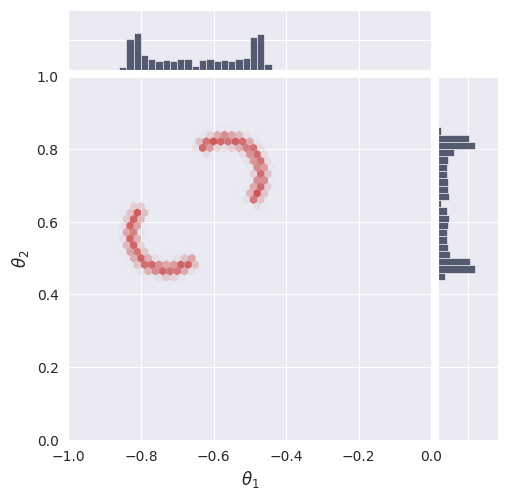

In [9]:
# plot the 2D posterior 
plot_marginals(np.asarray(reference_samples, dtype=np.float32), gridsize=50,range=[(-1,0),(0,1)], plot_levels=False, backend="seaborn")
plt.show()

In [10]:
# make a dataset
nsamples = int(1e5)

In [11]:
# Set batch size for training. Larger batch sizes help prevent overfitting, but are limited by available GPU memory.
batch_size = 4096
# Create training and validation datasets using the Two Moons task object.
train_dataset = task.get_train_dataset(batch_size)
val_dataset = task.get_val_dataset(batch_size)

# Create iterators for the training and validation datasets.
dataset_iter = iter(train_dataset)
val_dataset_iter = iter(val_dataset)

## 3. Model Configuration & Definition <a class="anchor" id="3"></a>
---
In this section, we load the model and optimizer configuration, set all relevant parameters, and instantiate the Flux1 model. Edge masks and marginalization functions are used for flexible inference and posterior estimation.

In [12]:
from gensbi.recipes import Flux1FlowPipeline

In [13]:
import yaml

# Path to the flux1 flow-matching configuration file.
config_path = f"{notebook_path}/config/config_flow_flux.yaml"


In [14]:
# Extract dimensionality information from the task object.
dim_obs = task.dim_obs  # Number of parameters to infer
dim_cond = task.dim_cond    # Number of observed data dimensions

dim_joint = task.dim_joint  # Joint dimension (for model input)

In [15]:
pipeline = Flux1FlowPipeline.init_pipeline_from_config(
        train_dataset,
        val_dataset,
        dim_obs,
        dim_cond,
        config_path,
        checkpoint_dir,
    )

## 4. Training <a class="anchor" id="4"></a>
---
In this section, we train the flow matching model or restore a checkpoint.

In [16]:
# pipeline.train(nnx.Rngs(0), 5, save_model=False)

In [17]:
pipeline.restore_model()

Restored model from checkpoint


## 5. Evaluation & Visualization <a class="anchor" id="5"></a>
---
In this section, we evaluate the trained Simformer model by sampling from the posterior, and comparing results to reference data. We also compute and visualize the unnormalized log probability over a grid to assess model calibration and density estimation. These analyses provide insight into model performance and reliability.

### Section 5.1: Posterior Sampling
---
In this section, we sample from the posterior distribution using the trained model and visualize the results. Posterior samples are generated for a selected observation and compared to reference samples to assess model accuracy.

In [18]:
# we want to do conditional inference. We need an observation for which we want to ocmpute the posterior
def get_samples(idx, nsamples=10_000, use_ema=False, key=None):
    observation, reference_samples = task.get_reference(idx)
    true_param = jnp.array(task.get_true_parameters(idx))

    if key is None:
        key = jax.random.PRNGKey(42)

    time_grid = jnp.linspace(0,1,100)

    samples = pipeline.sample(key, observation, nsamples, use_ema=use_ema, time_grid=time_grid)
    return samples, true_param, reference_samples

In [34]:
samples, true_param, reference_samples =  get_samples(8)

In [35]:
samples.shape # (100, 10000, 2)

(100, 10000, 2, 1)

### Section 5.2: Visualize Posterior Samples
---
In this section, we plot the posterior samples as a 2D histogram to visualize the learned distribution and compare it to the ground truth.

In [36]:
from gensbi.utils.plotting import plot_marginals, plot_2d_dist_contour

<Figure size 640x480 with 0 Axes>

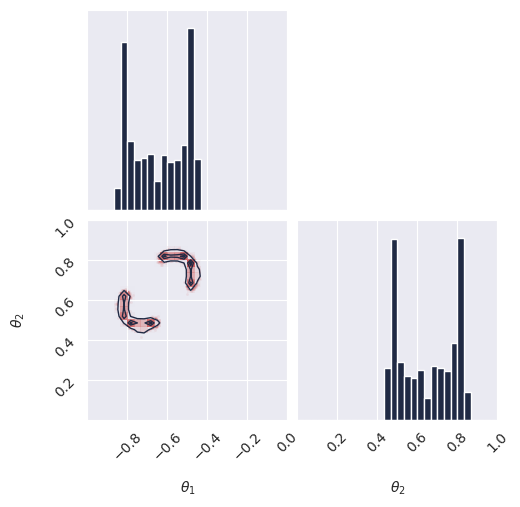

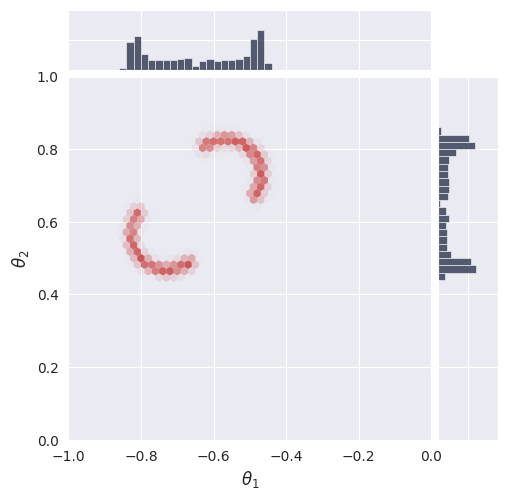

In [37]:
plot_marginals(samples[-1,...,0], plot_levels=False, gridsize=30, range=[(-1., 0), (0, 1.)])
plt.show()

# check how we set the ranges in the seaborn plot, it seems wrong
plot_marginals(samples[-1,...,0], plot_levels=False, backend="seaborn", gridsize=50, range =[(-1., 0), (0, 1.)])
# plt.text(1.05, 1.05, f"t = {1.0}", transform=plt.gca().transAxes)
plt.show()

### 5.3. Animations
---
In this section, we create and display animations of posterior samples and density contours over time. These visualizations illustrate the evolution of the learned distribution during the sampling process, providing dynamic insight into model behavior and convergence.

In [23]:
import imageio.v3 as imageio
import io
from tqdm import tqdm

In [24]:
# samples

images = []

for i in tqdm(range(len(samples))):
    fig, axes = plot_marginals(
        samples[i,...,0],
        plot_levels=False,
        gridsize=50,
        range=[(-1.0, 0), (0, 1.0)],
        backend="seaborn",
    )

    # manually set the ticks to make a prettier plot
   
    axes[0,0].set_ylim(0,6)
    axes[0,0].set_yticks([5])

    axes[1,1].set_xlim(0,6)
    axes[1,1].set_xticks([5])

    axes[1,1].text(0, 1.03, f"t = {(i+1)/len(samples):.2f}", transform=plt.gca().transAxes)

    buf = io.BytesIO()
    plt.savefig(buf, format="png", dpi=300)
    buf.seek(0)
    image = imageio.imread(buf)
    buf.close()
    if i == 0:
        images = []
    images.append(image)
    plt.close()

100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


In [25]:
# repeat the last frame 10 times to make the gif pause at the end
images += [images[-1]] * 20

In [26]:
imageio.imwrite(
    'animated_plot_samples.gif', 
    images, 
    duration=5000/len(images), 
    loop=0  # 0 means loop indefinitely
)

<img src="https://github.com/aurelio-amerio/GenSBI-examples/blob/main/examples/sbi-benchmarks/two_moons/flow_flux/animated_plot_samples_flux1.gif?raw=true" alt="slcp posterior sampling" width="50%">

## 6. Diagnostics <a class="anchor" id="6"></a>

In [27]:
import warnings
warnings.filterwarnings(
    "ignore", category=UserWarning, module="google.protobuf.runtime_version"
)

from gensbi.diagnostics import run_sbc, sbc_rank_plot
from gensbi.diagnostics import run_tarp, plot_tarp
from gensbi.diagnostics import LC2ST, plot_lc2st
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
import jax

In [28]:
num_calibration_samples = 200 #excercise: try 500, what changes?
num_posterior_samples = 1000 #excercise: try 10_000, what changes?

# Get test data
data = task.dataset["test"].with_format("jax")[:num_calibration_samples]
xs = jnp.asarray(data["xs"], dtype=jnp.bfloat16)
thetas = jnp.asarray(data["thetas"], dtype=jnp.bfloat16)

print(f"Sampling {num_posterior_samples} posterior samples for {num_calibration_samples} observations...")

# Generate posterior samples in batch
posterior_samples = pipeline.sample_batched(
    jax.random.PRNGKey(12345), xs, num_posterior_samples, use_ema=True
)

# Reshape for analysis
xs = xs.reshape((xs.shape[0], -1))
thetas = thetas.reshape((thetas.shape[0], -1))
posterior_samples = posterior_samples.reshape(
    (posterior_samples.shape[0], posterior_samples.shape[1], -1)
)

Sampling 1000 posterior samples for 200 observations...


Sampling: 100%|██████████| 20/20 [02:44<00:00,  8.23s/it]


### 6.1. TARP (Test of Accuracy and Reliability of Posterior)
We calculate the Expected Coverage Probability (ECP) to assess the calibration of the posterior.

Running TARP diagnostic...


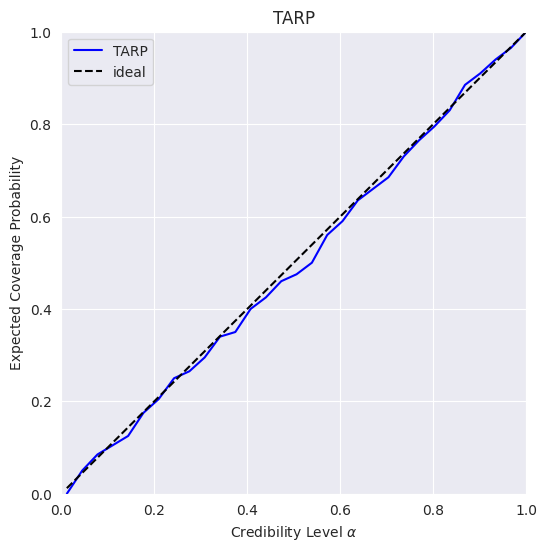

In [29]:
print("Running TARP diagnostic...")

# Calculate ECP and Alpha
ecp, alpha = run_tarp(
    thetas,
    posterior_samples,
    references=None,  # will be calculated automatically.
)

# Plot TARP
plot_tarp(ecp, alpha)
plt.title("TARP")
plt.show()

### 6.2. SBC (Simulation-Based Calibration)
We check the uniformity of the rank statistics.

Running SBC diagnostic...


Calculating ranks for 200 SBC samples: 100%|██████████| 200/200 [00:02<00:00, 94.72it/s] 


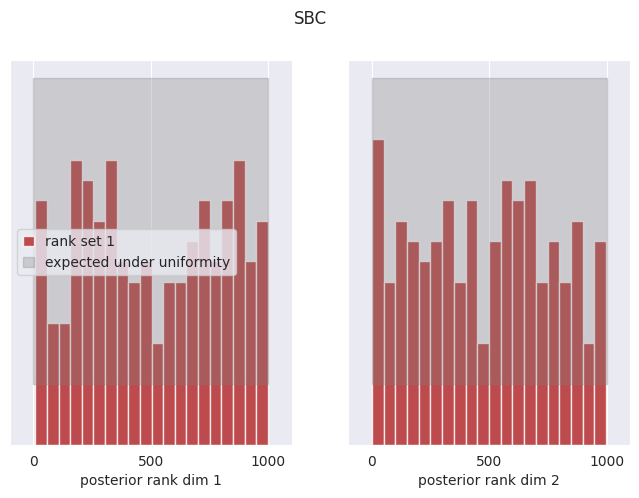

In [30]:
print("Running SBC diagnostic...")

# Compute ranks
ranks, dap_samples = run_sbc(thetas, xs, posterior_samples)

# Plot SBC
f, ax = sbc_rank_plot(ranks, num_posterior_samples, plot_type="hist", num_bins=20)
plt.suptitle("SBC")
plt.show()

### 6.3. L-C2ST (Local Classifier 2-Sample Test)
We train a classifier to distinguish between true and sampled parameters.

In [31]:
print("Running L-C2ST diagnostic...")

# 1. Prepare data for LC2ST
# We use a slightly larger set for training the classifier, but single sample per observation
num_lc2st_data = 10000
data_lc2st = task.dataset["test"].with_format("jax")[:num_lc2st_data]
xs_lc2st = jnp.asarray(data_lc2st["xs"], dtype=jnp.bfloat16)
thetas_lc2st = jnp.asarray(data_lc2st["thetas"], dtype=jnp.bfloat16)

# Sample 1 posterior sample per observation
posterior_samples_lc2st = pipeline.sample(
    jax.random.PRNGKey(43), xs_lc2st, num_lc2st_data, use_ema=True
)

# Reshape
thetas_lc2st_flat = thetas_lc2st.reshape(thetas_lc2st.shape[0], -1)
xs_lc2st_flat = xs_lc2st.reshape(xs_lc2st.shape[0], -1)
posterior_samples_lc2st_flat = posterior_samples_lc2st.reshape(posterior_samples_lc2st.shape[0], -1)

Running L-C2ST diagnostic...


In [32]:
# 2. Train the L-C2ST classifier
# Validation split happens inside LC2ST or we can hold out manually. 
# Here we hold out the last sample for visualization.
lc2st = LC2ST(
    thetas=thetas_lc2st_flat[:-1],
    xs=xs_lc2st_flat[:-1],
    posterior_samples=posterior_samples_lc2st_flat[:-1],
    classifier="mlp",
    num_ensemble=1,
)

print("Training classifier under null hypothesis...")
_ = lc2st.train_under_null_hypothesis()
print("Training classifier on observed data...")
_ = lc2st.train_on_observed_data()

# 3. Visualize on a held-out observation
x_o_star = xs_lc2st[-1:]
theta_o_star = thetas_lc2st[-1:]

# Sample many points for this specific observation to visualize the local score landscape
print("Sampling for visualization...")
post_samples_star = pipeline.sample(
    jax.random.PRNGKey(44), x_o_star[0], 10_000, use_ema=True
)

# Flatten for plotting
x_o_star_flat = x_o_star.reshape(1, -1)
post_samples_star_flat = np.array(
    post_samples_star.reshape(post_samples_star.shape[0], -1)
)

Training classifier under null hypothesis...


Training the classifiers under H0, permutation = True: 100%|██████████| 100/100 [13:25<00:00,  8.06s/it]


Training classifier on observed data...
Sampling for visualization...


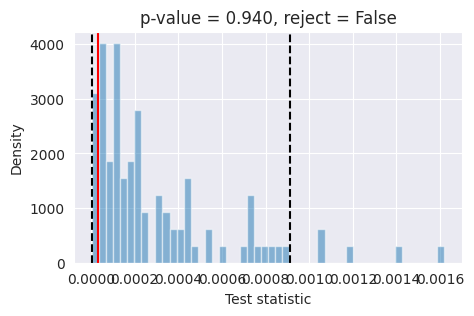

In [33]:
fig, ax = plot_lc2st(
    lc2st,
    post_samples_star_flat,
    x_o_star_flat,
)
plt.show()

> **Note:** <br>
> The model is overall well calibrated